In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup plotting theme
from tufte_mpl import setup, breathe, data_lim
setup()

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sympy as sp
from IPython.display import display, Math
%matplotlib inline

In [4]:
from neuron_populations import *

# Fixed vs. recurrent inhibition

## Excitatory population with self-coupling

$$\tau_k \dot h_k(t) = -h_k(t) + R_k \sum_n W_{kn} A_n(t) + R_k I_{ext,k}(t)$$

where

$$A_n(t) = \int_0^\infty \alpha_n(s) F_n(h_n(t-s)) \; \text{d}s$$

For each population $n$ :
- $\alpha(s)$ is the filtering kernel
- $F(h)$ is the gain function
- $A(t) = F(h(t))$ is the activity in the high noise (slow evolution) approximation
- $R$ the resistivity
- $W_{kn}$ the weight of currents from $n$ into $k$
- $I_{ext}(t)$ the external current
- $h(t)$ inner voltage of the population

### Varying constant $I_{ext}$

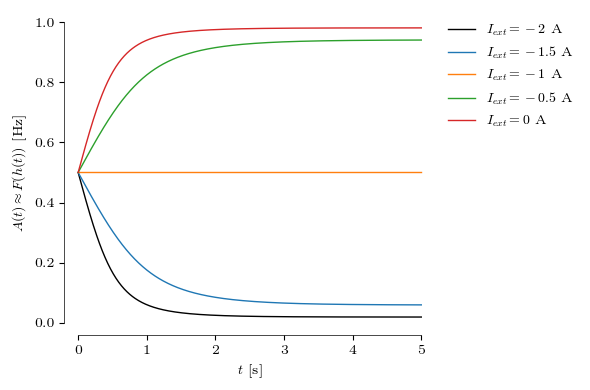

In [5]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-2, -1.5, -1, -0.5, 0):
	pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext))
	res = pop.simulate_h(np.array([0]), (0, 5), dt_max=0.01)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The activity levels out.

- $I_{ext} < -1 \; A$ : activity level decays to 0
- $I_{ext} = -1 \; A$ : threshold, activity level stays constant
- $I_{ext} > -1 \; A$ : activity level grows to 1

### Current spikes in steady state

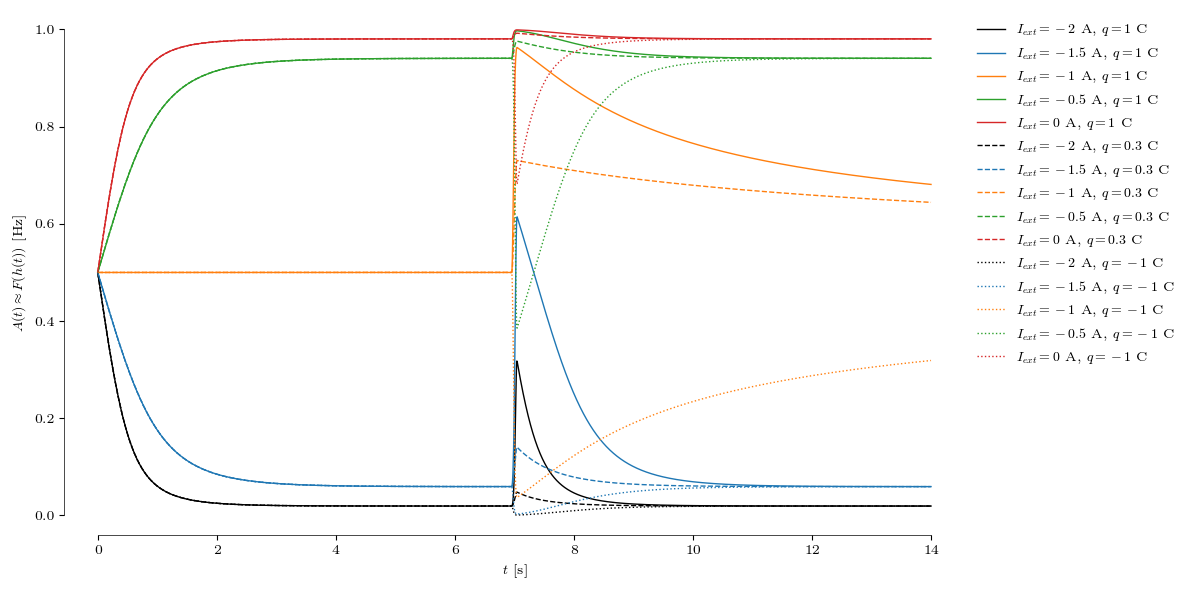

In [7]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
delta = Delta(7)

for idx, spike_charge in enumerate((1, 0.3, -1)):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-2, -1.5, -1, -0.5, 0):
		pop = Populations(W=np.array([[2]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext) + spike_charge*delta)
		res = pop.simulate_h(np.array([0]), (0, 14), dt_max=delta.eps/20)
		ax.plot(
			res.t, pop.gain_fn(res.y[0]),
			label=f'$I_{{ext}} = {I_ext}$ A, $q = {spike_charge}$ C',
			linestyle={0: 'solid', 1: 'dashed', 2: 'dotted'}.get(idx)
		)

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Current spike affects (higher amplitude, more time to recovery) unsaturated neurons ($|A| < 1$) more than saturated ones ($|A| \approx 1$).

It is not symmetric : if $A > 1/2$, then for $q < 0$ the perturbation is greather than for $q > 0$ (and vice-versa)

Larger spikes correspond to a higher amplitude response.

### Effect of coupling strength

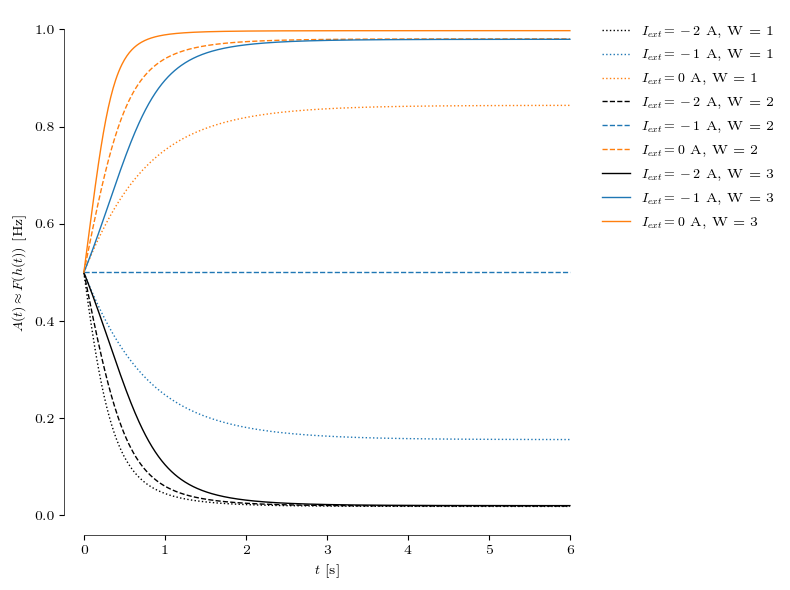

In [8]:
plt.close()
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

for W in (1, 2, 3):
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in (-2, -1, -0):
		pop = Populations(W=np.array([[W]]), tau=0.60, R=1, gain_fn=sigmoid, I_ext=Flat(I_ext))
		res = pop.simulate_h(np.array([0]), (0, 6), dt_max=0.01)
		ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A, W = {W}', linestyle={1: 'dotted', 2: 'dashed', 3: 'solid'}.get(W))

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

- Changing coupling can change the equilibrium ($I_{ext} = 0 \; A$), but also the rate of convergence to the equilibrium ($I_{ext} = - 2 \; A$)
- Less coupling leads to less activity at all times

### Linear rate network

We replace the logistic activation by an identity (linear activation with unitary coefficient to adapt units), making the network linear.

Using matrix notation where $\vec h = (h_1, \cdots, h_n)$, $\vec R = (R_1, \cdots, R_n)$, and $\odot$ is the elementwise product, we get

$$
\vec{\tau} \odot \dot{\vec h} = -\vec h + \vec R \odot W \vec h + \vec R \odot \vec{I_{ext}}
$$

If $I_{ext}$ is constant in time, the equation reduces to the form

$$
\vec h = \Alpha \vec h + \vec{\Beta} ,\; \text{with}\; \vec{h}(0) = \vec{h_0}
$$

which solves to

$$
\vec{h}(t) = 
\begin{cases}
\Alpha^{-1}(\text{exp}(\Alpha t)(\Alpha \vec{h_0} + \vec{\Beta}) - \vec{\Beta}) \quad \text{if $A$ is non-singular} \\
\vec{\Beta} t \quad \text{if $A = 0$} \\
\text{a sum of exponential and linear term in each component} \quad \text{if $A$ has null and non-null eigenvalues}
\end{cases}
$$

In this case,

$$
\Alpha = (1/\vec{\tau}) \odot (\vec R \odot W - \text{Id}) \\
\vec{\Beta} = (1/\vec{\tau}) \odot (\vec R \odot \vec{I_{ext}})
$$

In [328]:
def linear_solution(pop: Populations, y0: np.ndarray):
	alpha = (pop.R * pop.W - np.eye(*pop.W.shape)) / pop.tau[:, None]
	beta = (pop.R * pop.I_ext(0)) / pop.tau
	def h(t: float) -> np.ndarray:
		return np.linalg.inv(alpha) @ (scipy.linalg.expm(alpha * t) @ (alpha @ y0 + beta) - beta)
	def vec_h(t: np.ndarray) -> np.ndarray:
		hs = np.zeros((len(t), pop.W.shape[0]))
		return np.array([h(t_) for t_ in t])
	return vec_h

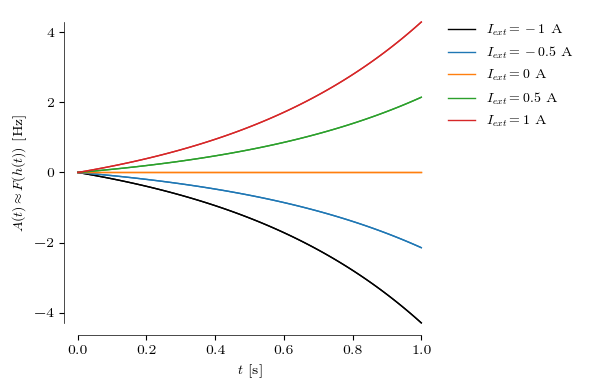

In [329]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for I_ext in (-1, -0.5, 0, 0.5, 1):
	pop = Populations(W=np.array([[2]]), tau=np.array([0.60]), R=1, gain_fn=identity, I_ext=Flat(np.array([I_ext])))
	res = pop.simulate_h(np.array([0]), (0, 1), dt_max=0.01)
	line, = ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'$I_{{ext}} = {I_ext}$ A')
	ax.plot(res.t, linear_solution(pop, np.array([0]))(res.t), color=line.get_color())

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
# ax.set_ylim((0, 1))
data_lim(ax, which='both')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

The solution is exponential, meaning it always explodes (for non-zero initial conditions).

So $I_{ext} < 0$ simulates an inhibitory current, but in this case, it is not enough to stabilize

## Inhibitation-stabilized network

### Stability of the network as function of excitatory self-coupling

We want to evaluate the stability of the solution

$$
\vec{y}(t) = \Alpha^{-1}(\text{exp}(\Alpha t)(\Alpha \vec{y_0} + \vec{\Beta}) - \vec{\Beta}).
$$

Rewriting $\vec v = \Alpha \vec{y_0} + \Beta$,

$$
\Alpha \vec{y}(t) = \text{exp}(\Alpha t) \vec v - \vec{\Beta}.
$$

The stability of the solution depends on the projection of $\vec{v}$ on the eigenspace of $\Alpha$. Components of $\vec{v}$ projected on an eigenspace associated to an eigenvalue

- $\lambda < 0$ vanish as $t \rightarrow \infty$
- $\lambda > 0$ diverge as $t \rightarrow \infty$
- $\lambda = 0$ are linear ($A$ is singular)

For the solution to be stable, we must therefore impose that all eigenvalues of $\Alpha$ are negative.

In [323]:
W00 = sp.Symbol('W_{00}', real=True)  # excit -> excit
W01 = sp.Symbol('W_{01}', real=True)  # inhib -> excit
W10 = sp.Symbol('W_{10}', real=True)  # exit -> inhib
W11 = sp.Symbol('W_{11}', real=True)  # inhib -> inhib
W = sp.Matrix([[W00, W01], [W10, W11]])

R = sp.Integer(1)
tau0, tau1 = sp.symbols('\\tau_0 \\tau_1', real=True)
tau = sp.Matrix([[tau0], [tau1]])
I0, I1 = sp.symbols('I_0 I_1', real=True)
I_ext = sp.Matrix([[I0], [I1]])

A = sp.Matrix((R * W - sp.Identity(2)))
A[0, :] /= tau0
A[1, :] /= tau1
B = sp.Matrix((R * I_ext))
B[0] /= tau0
B[1] /= tau1
h0 = sp.Matrix([[0], [0]])
hf = -A.inv() * B

display(Math(f'A = {sp.latex(A)}'))
display(Math(f'B = {sp.latex(B)}'))
display(Math(f'h_0 = {sp.latex(h0)}'))
display(Math(f'h_f = {sp.latex(hf)}'))

for i, eigval in enumerate(A.eigenvals()):
	print('---')
	display(Math(f'\\lambda_{i} = {sp.latex(eigval)}'))
	display(Math(f'W_{{00}}^\\star = {sp.latex(sp.solve(eigval, W00)[0])}'))

print('---')

subs = {
	W01: -4,
	W10: 4,
	W11: -7,
	tau0: 0.06,
	tau1: 0.012
}

W00_star = sp.solve(eigval, W00)[0]
W00_star_num = W00_star.evalf(subs=subs)
display(Math(f'W_{{00}}^\\star \\approx {sp.latex(W00_star_num)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

<IPython.core.display.Math object>

---


<IPython.core.display.Math object>

In this case, we can explicitly solve and find the system is stable when $W_{00} < W_{00}^\star = 3.0$. It diverges for $W_{00} > W_{00}^\star$ and evolves linearly when $W_{00} = W_{00}^\star$.

We denote $\vec{h_f} = \Alpha^{-1} \vec{\Beta}$ the value to which $\vec{h}$ converges. It depends on $W$, $\vec{I_{ext}}$, and more surprisingly $\tau$. In the case of one population, there was no "competition" and the system can converge at any speed. In the case of two populations, the competition means that now the rate of convergence matters.

Matrix([[5.00000000000000], [3.25000000000000]])
Matrix([[4.57740602766266e+77], [-1.70069631067308e+77]])
Matrix([[-5.00000000000000], [-1.75000000000000]])


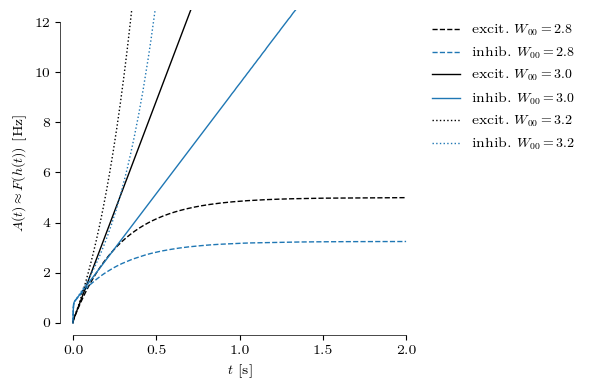

In [345]:
plt.close()
fig, ax = plt.subplots(dpi=100)

for idx, W00_num in enumerate((2.8, 3.0, 3.2)):
	ax.set_prop_cycle(None)

	pop = Populations(W=np.array([[W00_num, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=identity, I_ext=Flat(np.array([4.0, 6.0])))
	res = pop.simulate_h(np.array([0, 0]), (0, 2))
	
	subs_ = subs | {W00: W00_num, I0: 4.0, I1: 6.0}
	print(hf.evalf(subs=subs_))
	
	linestyle = {0: 'dashed', 1: 'solid', 2: 'dotted'}.get(idx)
	ax.plot(res.t, pop.gain_fn(res.y[0]), label=f'excit. $W_{{00}} = {W00_num}$', linestyle=linestyle)
	ax.plot(res.t, pop.gain_fn(res.y[1]), label=f'inhib. $W_{{00}} = {W00_num}$', linestyle=linestyle)

	# h_sol = linear_solution(pop, np.array([0, 0]))(res.t)
	# ax.plot(res.t, h_sol[:, 0])
	# ax.plot(res.t, h_sol[:, 1])

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 12))
data_lim(ax, which='x')
breathe(ax)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TODO : is sigmoidal similar to linear ? when are they equiv ?

### f-I curve

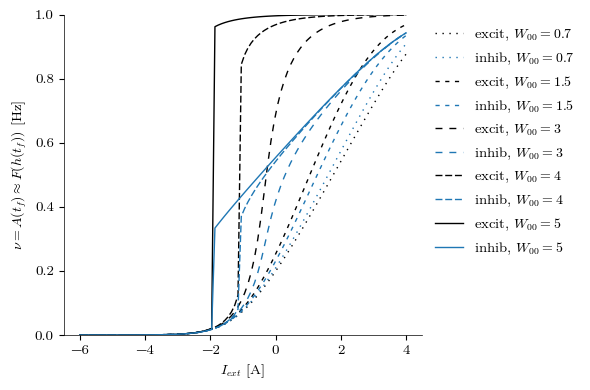

In [69]:
fig, ax = plt.subplots(dpi=100)
I_exts = np.linspace(-6, 4, 100)

for W00 in (0.7, 1.5, 3, 4, 5):
	fs = []
	ax.set_prop_cycle(None)  # reset color cycle

	for I_ext in I_exts:
		pop = Populations(W=np.array([[W00, -4], [4, -7]]), tau=np.array([0.06, 0.012]), R=1, gain_fn=sigmoid, I_ext=Flat(np.array([I_ext, I_ext])))
		res = pop.simulate_h(np.array([0, 0]), (0, 2), dt_max=0.01)
		fs.append(pop.gain_fn(res.y[:, -1]))

	ax.plot(I_exts, fs, linestyle={0.7: (0, (1, 4)), 1.5: (0, (3, 4)), 3: (0, (5, 5)), 4: (0, (5, 2)), 5: 'solid'}.get(W00), label=[f'excit, $W_{{00}} = {W00}$', f'inhib, $W_{{00}} = {W00}$'])

ax.set_xlabel('$I_{ext}$ [A]')
ax.set_ylabel('$\\nu = A(t_f) \\approx F(h(t_f))$ [Hz]')
ax.set_ylim((0, 1))
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TODO : role of inhibitory population ?
- strong excit self coupling : prevent divergence ?
- weak excit self coupling : create a smooth transition ?
- very weak excit self coupling : the inhib now has most activity

-> transfer of activity between excit and inhib

TODO : redo this f-I curve for the stable networks

TODO : mathematical derivation. this should be easy now that I know that F is linear in this model

# Modeling surround suppression

## Network mechanisms of surround suppression

Surround stimulus = more nearby neurons are excited -> nearby neighbours add currents -> higher or lower activitiy of the center

For surround suppression, we have a population of neighbour neurons which add a negative current contribution to the center, which is modeled by the inhibitory population.

The central neuron(s) is modeled as the excitatory population.

By increasing the current to the inhibitory population, we are modeling exciting more of the surrounding population.

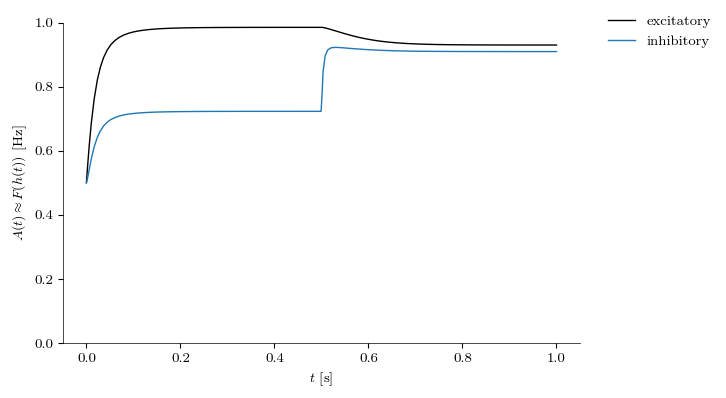

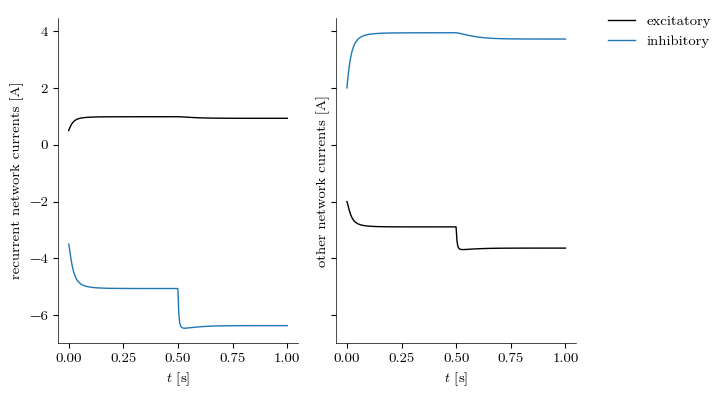

In [82]:
pop = Populations(
	W=np.array([[1, -4], [4, -7]]),
	tau=np.array([0.06, 0.012]),
	R=1,
	gain_fn=sigmoid,
	I_ext=(1-Heaviside(0.5))*Flat(np.array([4.0, 1.6])) + Heaviside(0.5)*Flat(np.array([4.0, 3.8]))
)
res = pop.simulate_h(np.array([0, 0]), (0, 1), dt_max=0.01)

# plot activations

plt.close()
fig, ax = plt.subplots(dpi=100)
ax.plot(res.t, pop.gain_fn(res.y[0]), label='excitatory')
ax.plot(res.t, pop.gain_fn(res.y[1]), label='inhibitory')

ax.set_xlabel('$t$ [s]')
ax.set_ylabel('$A(t) \\approx F(h(t))$ [Hz]')
ax.set_ylim((0, 1))
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# plot currents

plt.close()
fig, ax = plt.subplots(dpi=100, ncols=2, sharey=True)

ax[0].plot(res.t, [pop.I_network_recurrent(h) for h in res.y.T])
# ax.set_prop_cycle(None)  # reset color cycle
ax[1].plot(res.t, [pop.I_network_others(h) for h in res.y.T], label=['excitatory', 'inhibitory'])

ax[0].set_xlabel('$t$ [s]')
ax[1].set_xlabel('$t$ [s]')
ax[0].set_ylabel('recurrent network currents [A]')
ax[1].set_ylabel('other network currents [A]')
fig.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TODO : i am expecting excitatory to drop when the inhibitory current increases, but not always ?
- strong excit self coupling : no effect
- weak excit self coupling : excit starts to lose activity
- very weak excit self coupling : inhib has more activity

TODO : vary ``W00`` on figure

## Orientation tuning of surround suppression

TODO : make weights propto cos(delta angle between neurons) ? (delta = 0 -> maximum weight, delta = pi/2 -> minimum weight). NO ! We make the inhib population current less if not aligned, and more if aligned

## Surround suppression in networks with bio-plausible connectivity

TODO : 
- which equation for each neuron ? exactly the same as before, applied to each neuron ? YES. TODO : discuss how valid this approximation is (the pop equation is the mean field, it could work for describing a single neuron, but as we saw at the start of the course, it might be more complicated)
- do we implement sparse connections ?
- do we implement log-normal distribution of weights ?